In [1]:
import ee
import pandas as pd
import numpy as np

import rasterio

import plotnine
from plotnine import *

import requests
from tqdm.auto import tqdm

In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

### First, check if the attainable yield of different rcps/[Current/Best_occuring] have siginificant differences

In [5]:
img_Wheat_best = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'best',
          crop = ['Wheat'],
          time = ['2040','2070','2100'],
          climate_model = ['GFDL_ESM2M','HadGEM2_ES','IPSL_CM5A_LR','MIROC_ESM_CHEM','NorESM1_M'],
          rcp = ['26','45','60','85'],
          co2 = 'With_CO2',
          input_level = 'High',
          )

img_Wheat_current = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Wheat'],
          time = ['2040','2070','2100'],
          climate_model = ['GFDL_ESM2M','HadGEM2_ES','IPSL_CM5A_LR','MIROC_ESM_CHEM','NorESM1_M'],
          rcp = ['26','45','60','85'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Irrigation'],
          exclusion = 'All'
          )

In [6]:
# function to extract raster values using random_pts
def iter_df_to_extract_val(in_df):
  # # hack to show progress bar
  # print(' ',end='',flush=True)
  
  # loop through each row
  val_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    raster = ee.Image(row['GEE_path'])
    vals = ee.ImageCollection(raster).getRegion(geometry=random_pts,scale=7000).getInfo()
    val_df = pd.DataFrame(data=vals[1:],columns=vals[0])

    val_list.append(val_df['b1'].tolist())

  # add val_list to in_df
  out_df = in_df.copy()
  out_df['rand_val'] = val_list

  return out_df

# explode df and set datatype
def df_explode(df):

  df = df.explode('rand_val')
  df = df.reset_index(drop=True)

  df['rcp'] = df['rcp'].astype("category")
  df['climate_model'] = df['climate_model'].astype('string')
  df['time'] = df['time'].astype('int')
  df['rand_val'] = df['rand_val'].astype('float')

  return df


In [ ]:
# import NCL shp
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get 1k random points
random_pts = ee.FeatureCollection.randomPoints(region = NCP_shp)

# extract raster values 
print('Extracting raster values for 【Best】！')
img_Wheat_val_best = img_Wheat_best.copy()
img_Wheat_val_best_df = parallelize_dataframe(img_Wheat_val_best,iter_df_to_extract_val,20)
img_Wheat_val_best_df = df_explode(img_Wheat_val_best_df)

print('Extracting raster values for 【Current】！')
img_Wheat_val_current = img_Wheat_current.copy()
img_Wheat_val_current_df = parallelize_dataframe(img_Wheat_val_current,iter_df_to_extract_val,15)
img_Wheat_val_current_df = df_explode(img_Wheat_val_current_df)

img_Wheat_val_current_df_left = img_Wheat_val_current_df[img_Wheat_val_current_df['water'] == 'Rainfed']
img_Wheat_val_current_df_right = img_Wheat_val_current_df[img_Wheat_val_current_df['water'] == 'Irrigation']

c:\conda\envs\gee\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 5461 rows containing non-finite values.
c:\conda\envs\gee\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\conda\envs\gee\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 1980 rows containing non-finite values.
c:\conda\envs\gee\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\conda\envs\gee\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be 

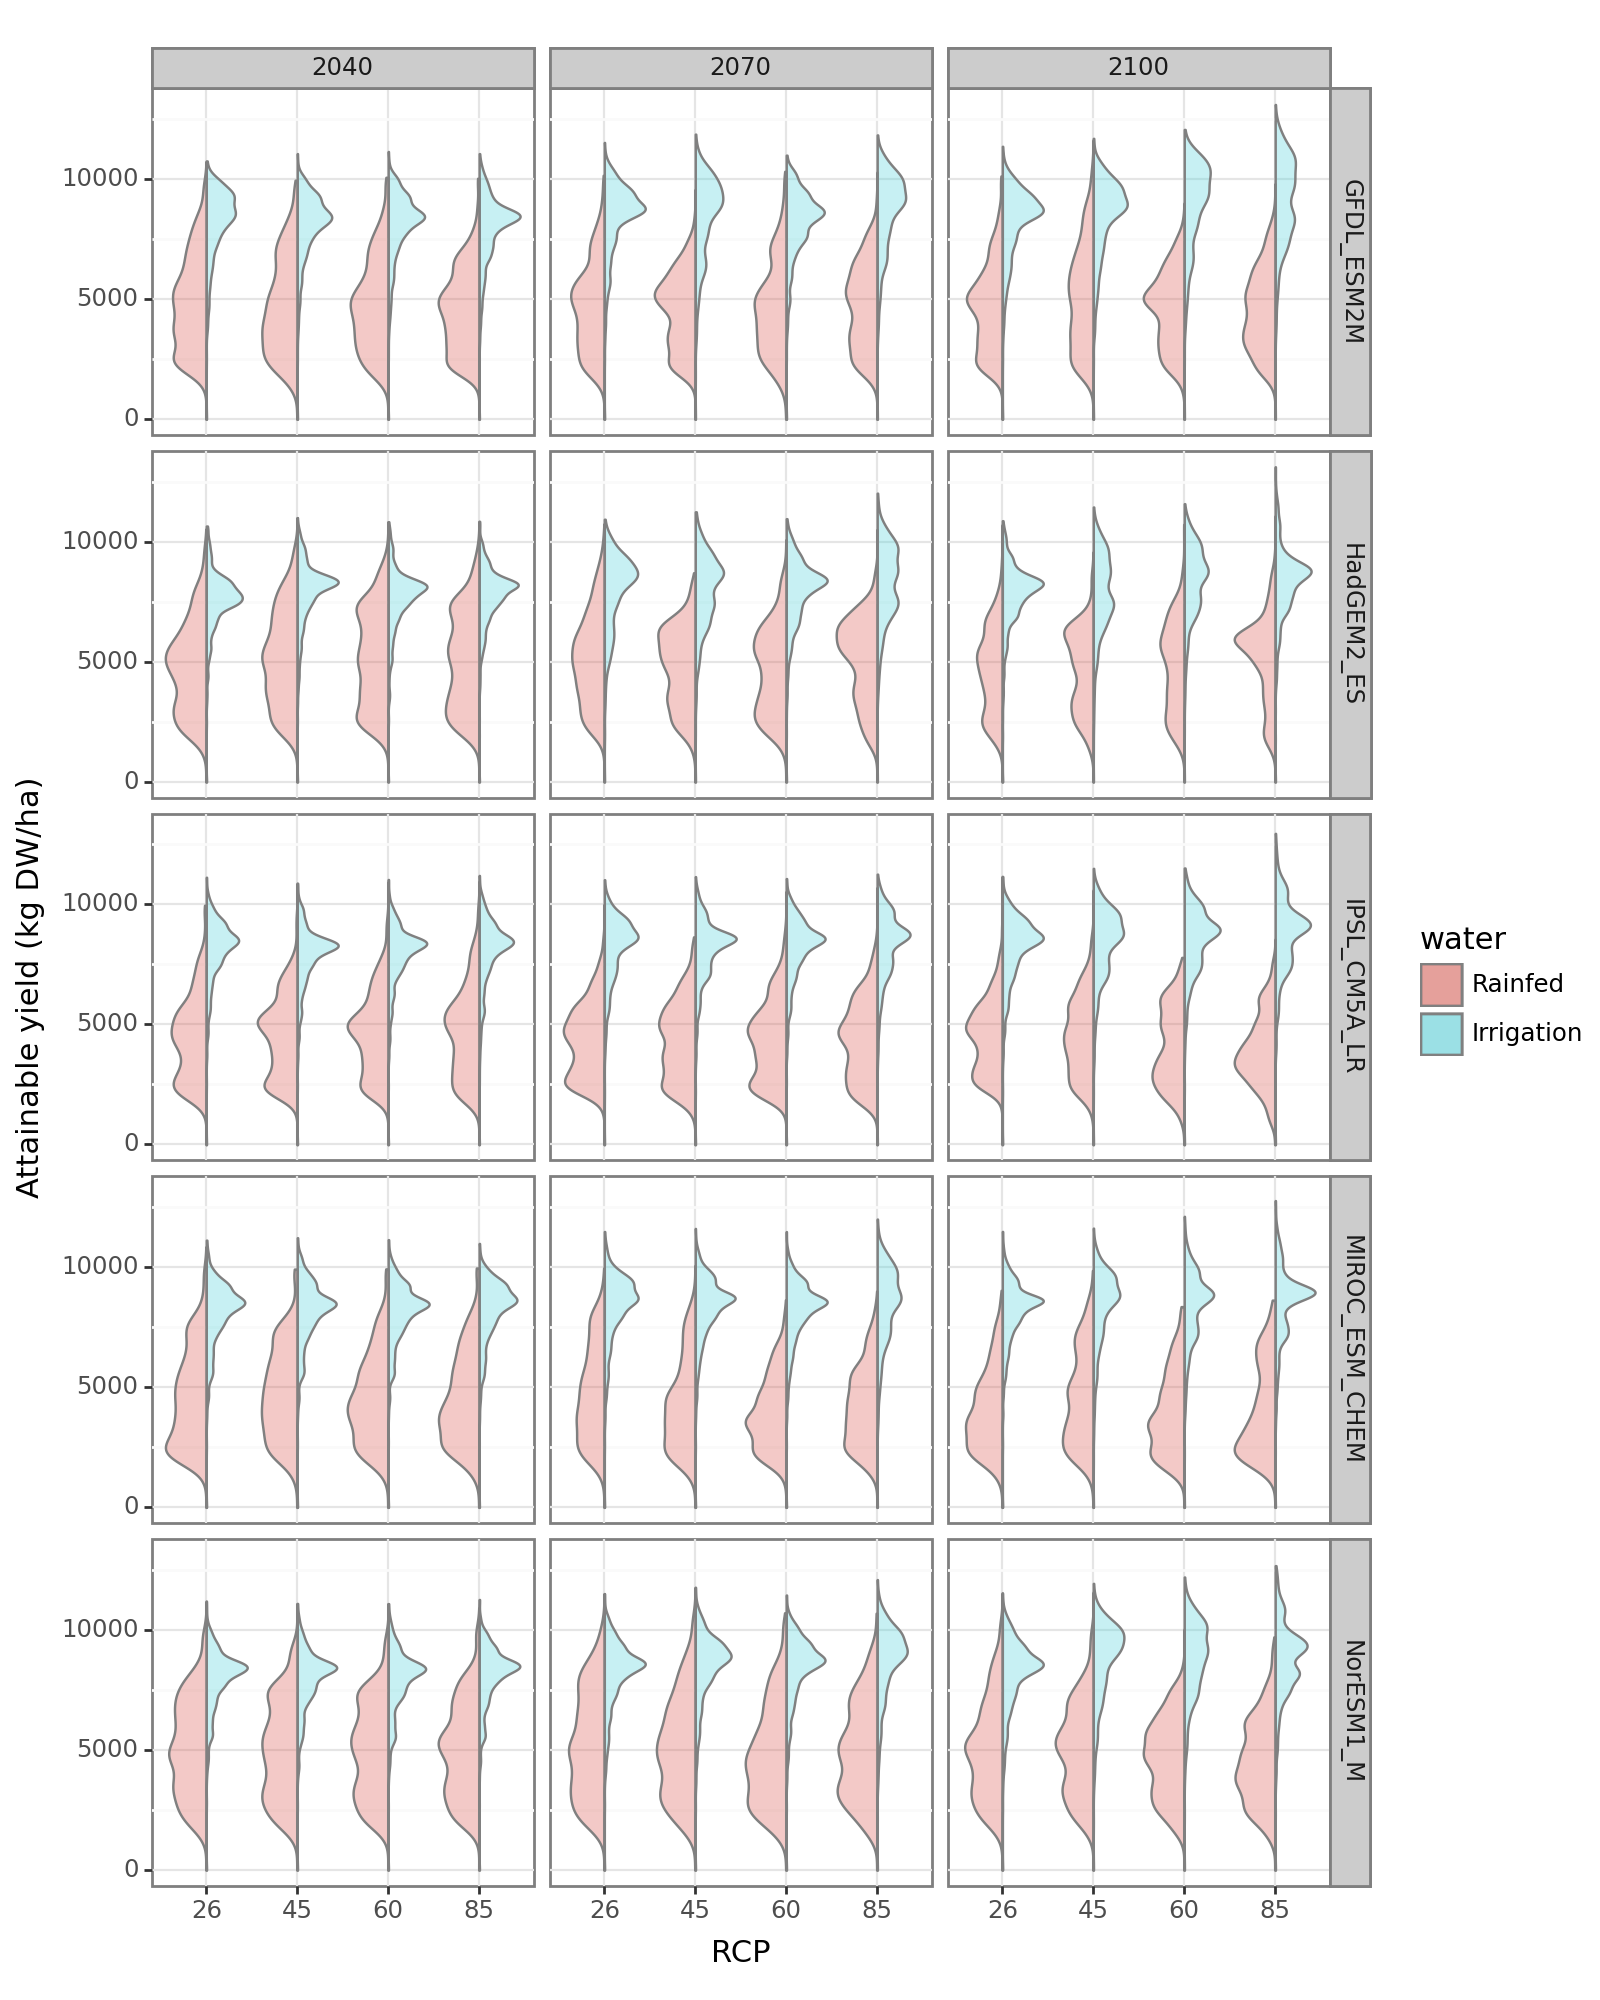

<Figure Size: (800 x 1000)>

In [8]:
plotnine.options.figure_size = (8, 10)
plotnine.options.dpi = 100

(ggplot()+
 geom_violin(aes(x='rcp',y='rand_val',fill='water',), data = img_Wheat_val_current_df_left, style='left', color='grey',alpha=1/3) +
 geom_violin(aes(x='rcp',y='rand_val',fill='water'), data = img_Wheat_val_current_df_right, style='right',color='grey',alpha=1/3) +
 facet_grid('climate_model~time') +
 theme_bw() +
 scale_fill_manual(values=['#db5f57','#57d3db'])+
 xlab('RCP')+
 ylab('Attainable yield (kg DW/ha)')
 )

c:\conda\envs\gee\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 5521 rows containing non-finite values.
c:\conda\envs\gee\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\conda\envs\gee\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\conda\envs\gee\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

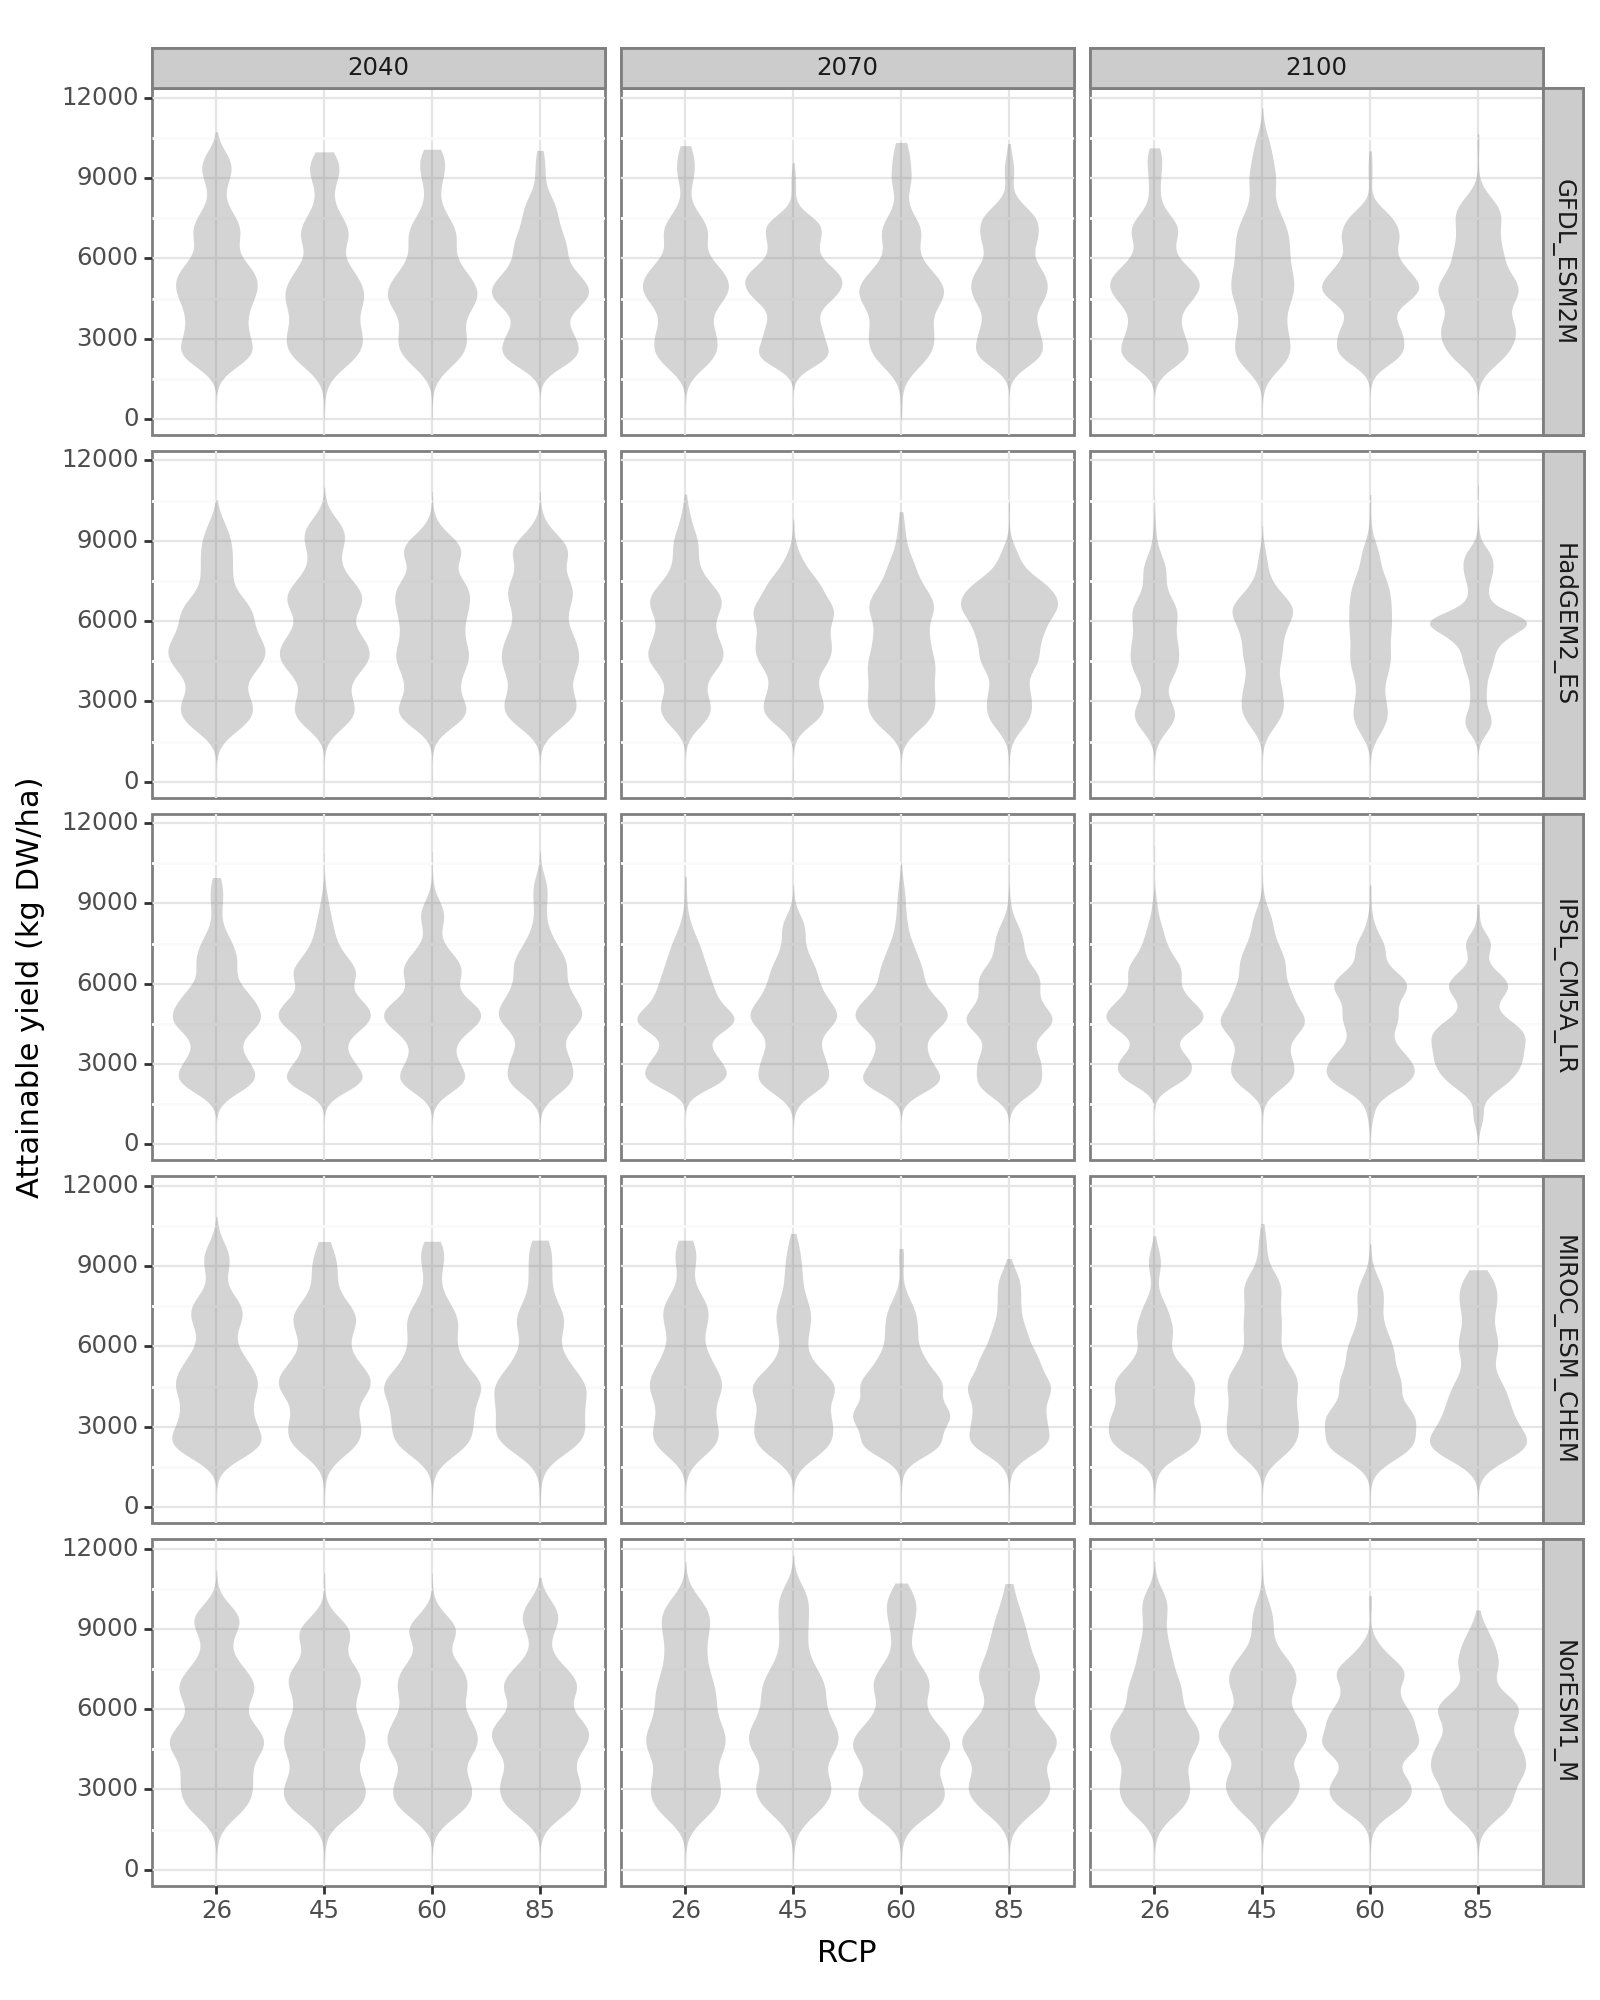

<Figure Size: (800 x 1000)>

In [9]:
plotnine.options.figure_size = (8, 10)
plotnine.options.dpi = 100

(ggplot(data=img_Wheat_val_best_df)+
 geom_violin(aes(x='rcp',y='rand_val'),fill='grey',alpha=1/3,color='') +
 facet_grid('climate_model~time') +
 theme_bw()+
 xlab('RCP')+
 ylab('Attainable yield (kg DW/ha)')
 )

### filter the attainable production

In [10]:
# get the historical imgs
img_Maize = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Maize'],
          time = ['1990','2000','2010',],
          climate_model = 'CRUTS32',
          rcp = ['Historical'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Sprinkler'],
          exclusion = 'All'
          )

img_Wetland_rice = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Wetland_rice'],
          time = ['1990','2000','2010',],
          climate_model = 'CRUTS32',
          rcp = ['Historical'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Gravity'],
          exclusion = 'All'
          )

img_Wheat = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Wheat'],
          time = ['1990','2000','2010',],
          climate_model = 'CRUTS32',
          rcp = ['Historical'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Irrigation'],
          exclusion = 'All'
          )

# concate all img to one df
img_attainable_historical = pd.concat([img_Maize,img_Wetland_rice,img_Wheat])
img_attainable_historical['time'] = img_attainable_historical['time'].astype('int')
img_attainable_historical['water'] = img_attainable_historical['water'].apply(lambda x:'Rainfed' if x=='Rainfed' else 'Irrigated')
img_attainable_historical

,theme,attain_type,crop,time,climate_model,rcp,co2,input_level,water,GEE_path
0,GAEZ_4,current,Maize,1990,CRUTS32,Historical,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
1,GAEZ_4,current,Maize,1990,CRUTS32,Historical,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
2,GAEZ_4,current,Maize,2000,CRUTS32,Historical,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
3,GAEZ_4,current,Maize,2000,CRUTS32,Historical,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
4,GAEZ_4,current,Maize,2010,CRUTS32,Historical,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
5,GAEZ_4,current,Maize,2010,CRUTS32,Historical,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
0,GAEZ_4,current,Wetland_rice,1990,CRUTS32,Historical,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
1,GAEZ_4,current,Wetland_rice,1990,CRUTS32,Historical,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
2,GAEZ_4,current,Wetland_rice,2000,CRUTS32,Historical,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
3,GAEZ_4,current,Wetland_rice,2000,CRUTS32,Historical,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...


In [11]:
# get the 2040/2070/2100 imgs
img_Maize = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Maize'],
          time = ['2040','2070','2100'],
          climate_model = ['GFDL_ESM2M','HadGEM2_ES','IPSL_CM5A_LR','MIROC_ESM_CHEM','NorESM1_M'],
          rcp = ['26','45','60','85'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Sprinkler'],
          exclusion = 'All'
          )

img_Wetland_rice = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Wetland_rice'],
          time = ['2040','2070','2100'],
          climate_model = ['GFDL_ESM2M','HadGEM2_ES','IPSL_CM5A_LR','MIROC_ESM_CHEM','NorESM1_M'],
          rcp = ['26','45','60','85'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Gravity'],
          exclusion = 'All'
          )

img_Wheat = get_img_df(img_path = GAEZ_list,
          theme = 'GAEZ_4',
          attain_type = 'current',
          crop = ['Wheat'],
          time = ['2040','2070','2100'],
          climate_model = ['GFDL_ESM2M','HadGEM2_ES','IPSL_CM5A_LR','MIROC_ESM_CHEM','NorESM1_M'],
          rcp = ['26','45','60','85'],
          co2 = 'With_CO2',
          input_level = 'High',
          water = ['Rainfed','Irrigation'],
          exclusion = 'All'
          )

# concate all img to one df
img_attainable_future = pd.concat([img_Maize,img_Wetland_rice,img_Wheat])
img_attainable_future['time'] = img_attainable_future['time'].astype('int')
img_attainable_future['water'] = img_attainable_future['water'].apply(lambda x:'Rainfed' if x=='Rainfed' else 'Irrigated')
img_attainable_future

('GAEZ_4', 'current', 'Wetland_rice', '2100', 'MIROC_ESM_CHEM', '45', 'With_CO2', 'High', 'Gravity') have no coresponding img!


,theme,attain_type,crop,time,climate_model,rcp,co2,input_level,water,GEE_path
0,GAEZ_4,current,Maize,2040,GFDL_ESM2M,26,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
1,GAEZ_4,current,Maize,2040,GFDL_ESM2M,26,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
2,GAEZ_4,current,Maize,2040,GFDL_ESM2M,45,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
3,GAEZ_4,current,Maize,2040,GFDL_ESM2M,45,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
4,GAEZ_4,current,Maize,2040,GFDL_ESM2M,60,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
...,...,...,...,...,...,...,...,...,...,...
115,GAEZ_4,current,Wheat,2100,NorESM1_M,45,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
116,GAEZ_4,current,Wheat,2100,NorESM1_M,60,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...
117,GAEZ_4,current,Wheat,2100,NorESM1_M,60,With_CO2,High,Irrigated,projects/earthengine-legacy/assets/users/wangj...
118,GAEZ_4,current,Wheat,2100,NorESM1_M,85,With_CO2,High,Rainfed,projects/earthengine-legacy/assets/users/wangj...


In [13]:
# function to group gee_imgs by climate model and then compute the mean
def group_compute_mean(in_df):

  # get the col names for grouping
  col_group = in_df.columns[:-1].tolist()
  col_group.remove('climate_model')

  # group by climate models and compute the mean img
  df = pd.DataFrame(in_df.groupby(col_group)['GEE_path'].apply(lambda x : x.tolist())).reset_index()
  df['img_future_mean'] = df['GEE_path'].apply(lambda x: compute_mean_ci(x)[0])
  df['img_future_sd'] = df['GEE_path'].apply(lambda x: compute_mean_ci(x)[1])
  df['img_future_ci'] = df['GEE_path'].apply(lambda x: compute_mean_ci(x)[2])

  # remove unnecessary col
  df = df.drop(columns='GEE_path')
  
  return df

# compute the mean according to 5 climate models
img_attainable_future_mean = group_compute_mean(img_attainable_future)
# rename the values in 'water' column to either "Rainfed" or "Irrigated"
img_attainable_future_mean['water'] = img_attainable_future_mean['water'].apply(lambda x:'Rainfed' if x=='Rainfed' else 'Irrigated')
img_attainable_future_mean.head()

,theme,attain_type,crop,time,rcp,co2,input_level,water,img_future_mean,img_future_sd,img_future_ci
0,GAEZ_4,current,Maize,2040,26,With_CO2,High,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,GAEZ_4,current,Maize,2040,26,With_CO2,High,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,GAEZ_4,current,Maize,2040,45,With_CO2,High,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,GAEZ_4,current,Maize,2040,45,With_CO2,High,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,GAEZ_4,current,Maize,2040,60,With_CO2,High,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


### Interpolate the attainable yield of [2020-2040, 2021-2070, 2071-2100] to [2020, 2025, 2030, ... , 2100]

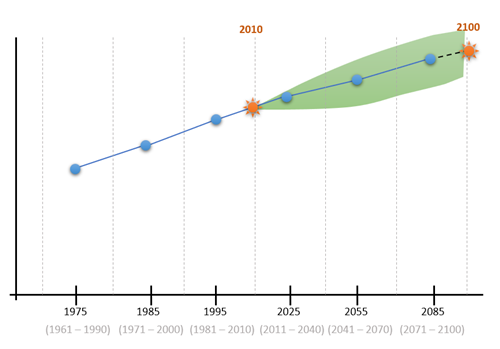

#### Build the interpolate functions

In [14]:
# functions to interpolate images
def interpolate_imgs_1975_2010(in_df):

  # get the img at the middle of each [1961-1990,1971-2000,1981-2010]  
  img_1975 = ee.Image(in_df[in_df['time'] == 1990]['GEE_path'].tolist()[0])
  img_1985 = ee.Image(in_df[in_df['time'] == 2000]['GEE_path'].tolist()[0])
  img_1995 = ee.Image(in_df[in_df['time'] == 2010]['GEE_path'].tolist()[0]) 

  # compute the stpe distance for each period
  step_1975_1985 = img_1985.subtract(img_1975).divide(10)
  step_1985_1995 = img_1995.subtract(img_1985).divide(10)

  # interpolate imgs
  imgs_1975_1985 = [img_1975.add(step_1975_1985.multiply(i)) for i in range(0,11,5)]
  imgs_1990_2010 = [img_1985.add(step_1985_1995.multiply(i)) for i in range(5,26,5)]
 
  imgs_interpolated = imgs_1975_1985 + imgs_1990_2010

  return imgs_interpolated

def interpolate_imgs_2015_2100(in_df,img_2010):

  img_2010 = ee.Image(img_2010)
  names = ['img_future_mean', 'img_future_sd', 'img_future_ci']

  # 1) get mean/std/ci imgs:
  # Note: e.g, time_y == 2040 <--> attainable yield of 2010-2040, 
  #        we take the middel year (2025) as represent data
  img_std_ci_2025 = [ee.Image(in_df[in_df['time'] == 2040][name].tolist()[0]) for name in names] 
  img_std_ci_2055 = [ee.Image(in_df[in_df['time'] == 2070][name].tolist()[0]) for name in names]
  img_std_ci_2085 = [ee.Image(in_df[in_df['time'] == 2100][name].tolist()[0]) for name in names]

  # 2)-1 compute the stpe-distance for each period
  step_2010_2025 = img_std_ci_2025[0].subtract(img_2010).divide(15)
  step_2025_2055 = img_std_ci_2055[0].subtract(img_std_ci_2025[0]).divide(30)
  step_2055_2085 = img_std_ci_2085[0].subtract(img_std_ci_2055[0]).divide(30)

  # 2)-2 interpolate imgs
  mean_2015_2025 = [img_2010.add(step_2010_2025.multiply(i)) for i in range(5,16,5)]
  mean_2030_2055 = [img_std_ci_2025[0].add(step_2025_2055.multiply(i)) for i in range(5,31,5)]
  mean_2060_2100 = [img_std_ci_2055[0].add(step_2055_2085.multiply(i)) for i in range(5,46,5)]

  mean_interpolated = mean_2015_2025 + mean_2030_2055 + mean_2060_2100

  # 3) get the [std, ci] for each period
  std_2015_2025 = [img_std_ci_2025[1]] * len(mean_2015_2025)
  std_2030_2055 = [img_std_ci_2055[1]] * len(mean_2030_2055)
  std_2060_2100 = [img_std_ci_2085[1]] * len(mean_2060_2100)

  std_imgs = std_2015_2025 + std_2030_2055 + std_2060_2100

  ci_2015_2025 = [img_std_ci_2025[2]] * len(mean_2015_2025)
  ci_2030_2055 = [img_std_ci_2055[2]] * len(mean_2030_2055)
  ci_2060_2100 = [img_std_ci_2085[2]] * len(mean_2060_2100)

  ci_imgs = ci_2015_2025 + ci_2030_2055 + ci_2060_2100

  # 4) zip img together

  imgs_interpolated = zip(mean_interpolated, std_imgs, ci_imgs)

  return imgs_interpolated

#### Interpolation

In [15]:
# loop throught each sub-df with the same ['crop','water','rcp']
interpolate_df_1975_2010 = []
for idx,df in img_attainable_historical.groupby(['crop','water','rcp']):
  interpolated_imgs = interpolate_imgs_1975_2010(df)
  interpolated_imgs = pd.DataFrame({'image':interpolated_imgs})

  interpolated_imgs[['crop','water','rcp']] = idx
  interpolated_imgs['year'] = range(1975,2011,5)

  interpolate_df_1975_2010.append(interpolated_imgs)

# append all dfs
interpolate_df_1975_2010_df = pd.concat(interpolate_df_1975_2010)

In [16]:
# loop throught each sub-df with the same ['crop','water','rcp']
interpolate_df = []
for idx,df in img_attainable_future_mean.groupby(['crop','water','rcp']):

  # get attainable yield in 2010
  crop,water,base_year = idx[0],idx[1],2010
  img_2010 = interpolate_df_1975_2010_df[(interpolate_df_1975_2010_df['crop']==crop)&
                        (interpolate_df_1975_2010_df['water']==water)&
                        (interpolate_df_1975_2010_df['year']==base_year)]\
                        ['image'].tolist()[0]


  # get the img of each ['multiplier_mean', 'multiplier_sd', 'multiplier_ci']
  out_df =  pd.DataFrame(interpolate_imgs_2015_2100(df,img_2010))
  out_df.columns = ['image','img_future_sd','img_future_ci']

  # add ['crop','water','rcp'] information to the resulted df
  out_df[['crop','water','rcp']] = idx
  out_df['year'] = range(2015,2101,5)

  interpolate_df.append(out_df)


# append all dfs
interpolate_df_2015_2100_df = pd.concat(interpolate_df)

In [17]:
interpolate_df_2015_2100_df

,image,img_future_sd,img_future_ci,crop,water,rcp,year
0,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,26,2015
1,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,26,2020
2,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,26,2025
3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,26,2030
4,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,26,2035
...,...,...,...,...,...,...,...
13,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2080
14,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2085
15,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2090
16,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2095


In [18]:
# concate two dfs
interpolate_df_full = pd.concat([interpolate_df_1975_2010_df,interpolate_df_2015_2100_df])

# save df to disk
interpolate_df_full.to_pickle('./result_csv/attainable_yield_interpolated.pkl')

# read the saving
interpolate_df_full = pd.read_pickle('./result_csv/attainable_yield_interpolated.pkl')

In [19]:
interpolate_df_full

,image,crop,water,rcp,year,img_future_sd,img_future_ci
0,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1975,NaN,NaN
1,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1980,NaN,NaN
2,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1985,NaN,NaN
3,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1990,NaN,NaN
4,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1995,NaN,NaN
...,...,...,...,...,...,...,...
13,"ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2080,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
14,"ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2085,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
15,"ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2090,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
16,"ee.Image({\n ""functionInvocationValue"": {\n ...",Wheat,Rainfed,85,2095,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### sanity check: --> plot the histogram


In [24]:
# fuction to filter data using [crop,water,year]
def get_img(df,year,rcp,water,crop,img_name):
  img = df[(df['crop']==crop)&
        (df['water']==water)&
        (df['rcp']==('Historical' if year <= 2010 else rcp))&
        (df['year']==year)][img_name].tolist()[0]

  return img

# function for sanity check
def get_array(img,year):
  geom = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary").geometry()
  url = img.getDownloadUrl(dict(name='img',region=geom,scale=7000,format='GEO_TIFF'))

  # get the data and read as array
  resp = requests.get(url)
  with open(f'result_imgs/test_{year}.tif','wb') as f:
    f.write(resp.content)

  # get the raster array
  ds = rasterio.open(f'result_imgs/test_{year}.tif')
  ds_arr = ds.read()
  arr_df = pd.DataFrame(ds_arr.reshape([-1]))
  arr_df.columns = ['val']
  arr_df['year'] = year
  arr_df['year'] = arr_df['year'].astype('category')

  # remove 5% outliers
  bot,up = np.quantile(arr_df['val'],(0.05,0.95))
  arr_df = arr_df[(arr_df['val'] > bot)&
            (arr_df['val'] < up)&
            (arr_df['val'] != 1.0)&
            (arr_df['val'] != 0)]

  return arr_df

def plot_hist(img_1,year_1,img_2,year_2):
  arr_1 = get_array(img_1,year_1)
  arr_2 = get_array(img_2,year_2)

  # plot the histogram
  plotnine.options.dip=100
  plotnine.options.figure_size = (6,6)
  
  plot = (ggplot() 
        + geom_histogram(arr_1,aes(x='val',fill='year'),alpha = 1/3) 
        + geom_histogram(arr_2,aes(x='val',fill='year'),alpha = 1/3) 
        + theme_bw() 
        + scale_fill_manual(values=['#db5f57','#57d3db'])
  )

  return plot

c:\conda\envs\gee\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 78'. Pick better value with 'binwidth'.
c:\conda\envs\gee\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000024B79E94860> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\conda\envs\gee\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 75'. Pick better value with 'binwidth'.
c:\conda\envs\gee\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000024B79E94860> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


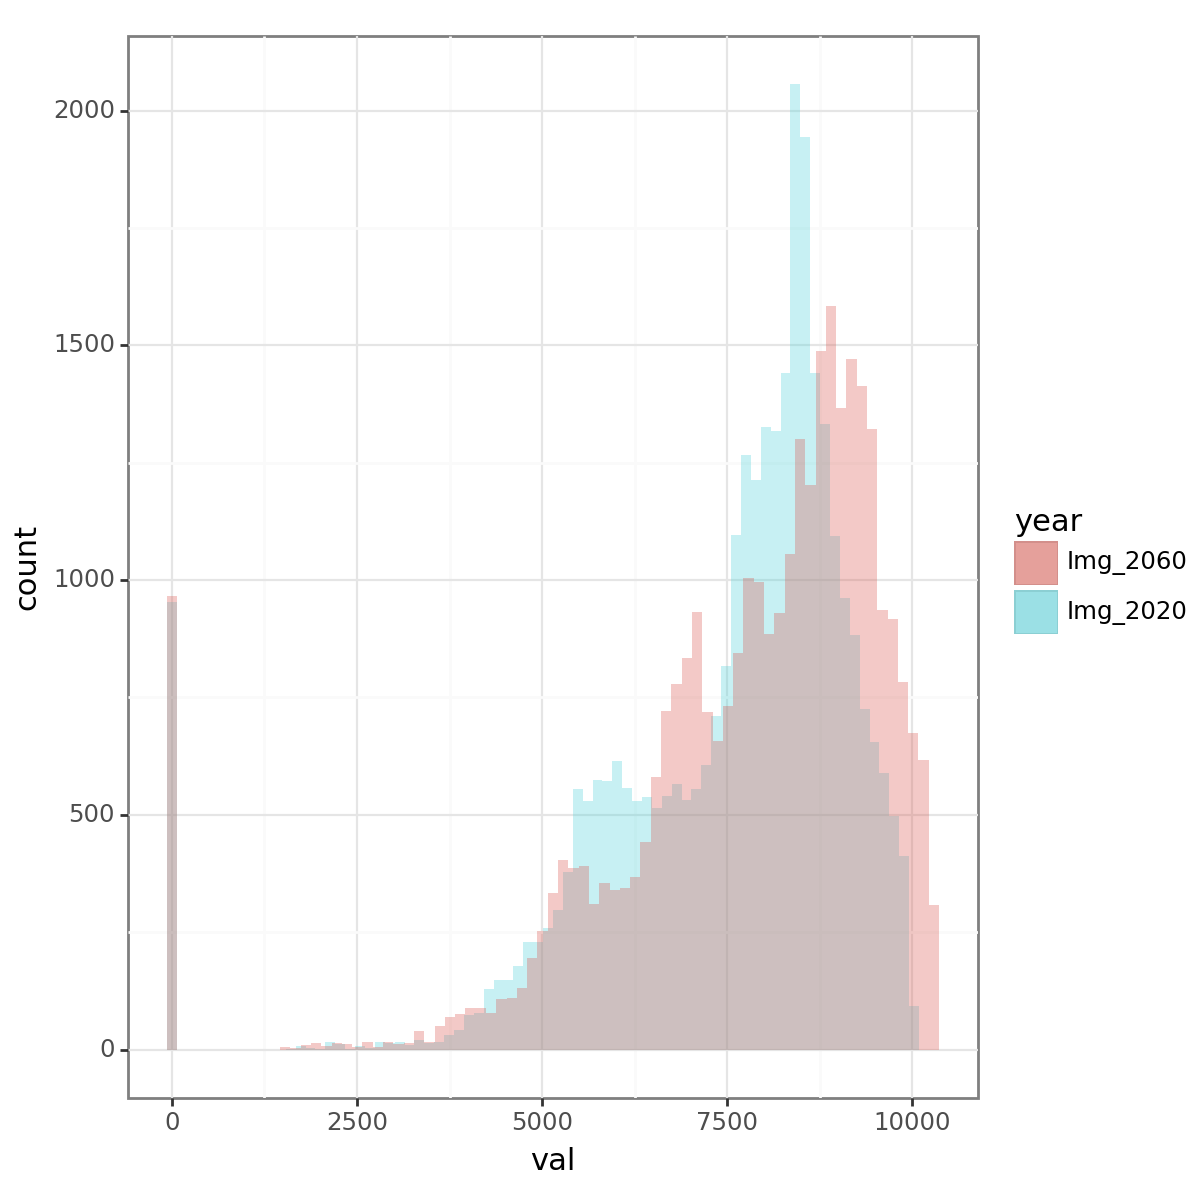

<Figure Size: (600 x 600)>

In [25]:
# instantiate the function to make plot
year_1 = 2020
year_2 = 2060
rcp  = '45'
water = 'Irrigated' # ['Irrigated','Rainfed']
crop = 'Wheat'    # ['Wheat','Maize','Wetland_rice]

img_1 = get_img(interpolate_df_full,year_1,rcp,water,crop,'image')
img_2 = get_img(interpolate_df_full,year_2,rcp,water,crop,'image')
plot_hist(img_1,f'Img_{year_1}',img_2,f'Img_{year_2}')

### Compute the multiplier from the attainable yield to project actual yield to 2010

In [26]:
# function to compute the multiplier
def compute_multiplier(row):

  # get row information 
  crop = row['crop']
  water = row['water']
  img_2010 = interpolate_df_full[(interpolate_df_full['crop']==crop)&
                   (interpolate_df_full['water']==water)&
                   (interpolate_df_full['year']==2010)]['image'].tolist()[0]
  
  # divide row['img'] with img_2010 to get the multiplierd
  if row['year'] <= 2010:
    multiplier = [row['image'].divide(img_2010),None,None]
  else:
    multiplier = [row[img_type].divide(img_2010) for img_type in ['image','img_future_sd','img_future_ci']]

  return multiplier

In [27]:
# 1) get the future attainable yield
futuer_attainable_multiplier = interpolate_df_full.copy()

# 2) compute the multiplier
futuer_attainable_multiplier[['multiplier_mean','multiplier_sd','multiplier_ci']] = futuer_attainable_multiplier.apply(lambda x:compute_multiplier(x),1).tolist()
futuer_attainable_multiplier.head()


,image,crop,water,rcp,year,img_future_sd,img_future_ci,multiplier_mean,multiplier_sd,multiplier_ci
0,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1975,NaN,NaN,"ee.Image({\n ""functionInvocationValue"": {\n ...",None,None
1,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1980,NaN,NaN,"ee.Image({\n ""functionInvocationValue"": {\n ...",None,None
2,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1985,NaN,NaN,"ee.Image({\n ""functionInvocationValue"": {\n ...",None,None
3,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1990,NaN,NaN,"ee.Image({\n ""functionInvocationValue"": {\n ...",None,None
4,"ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,Historical,1995,NaN,NaN,"ee.Image({\n ""functionInvocationValue"": {\n ...",None,None


In [28]:
# save to disk
futuer_attainable_multiplier.to_pickle('./result_csv/futuer_attainable_multiplier.pkl')

# read saving
futuer_attainable_multiplier= pd.read_pickle('./result_csv/futuer_attainable_multiplier.pkl')

#### sanity check: --> plot the histogram


c:\conda\envs\gee\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 82'. Pick better value with 'binwidth'.
c:\conda\envs\gee\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000024B79E94860> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\conda\envs\gee\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 57'. Pick better value with 'binwidth'.
c:\conda\envs\gee\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000024B79E94860> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


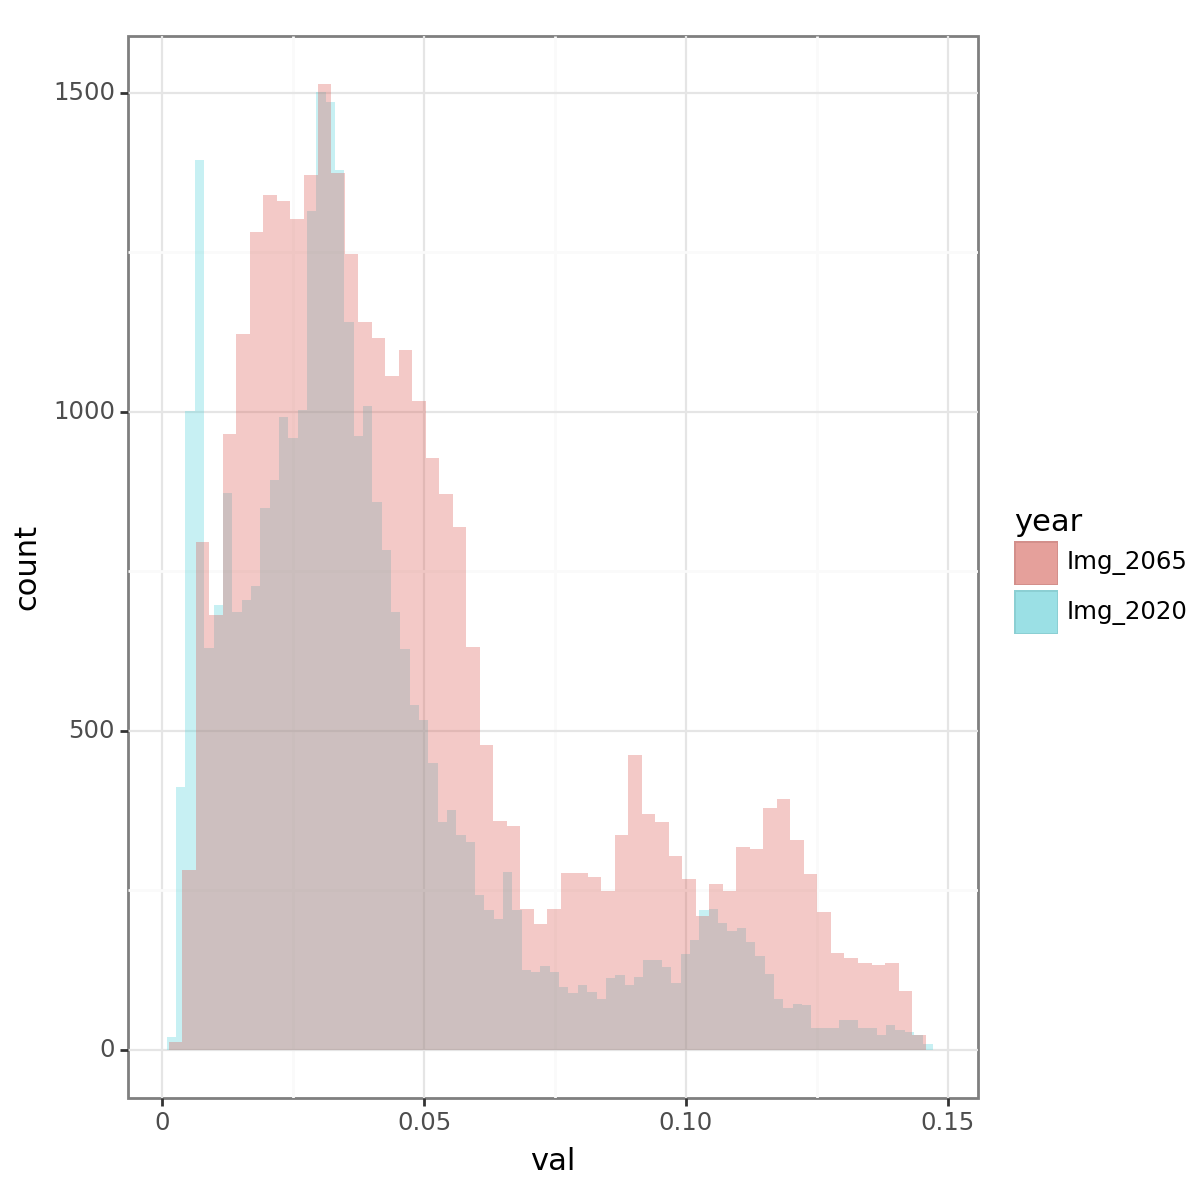

<Figure Size: (600 x 600)>

In [29]:
# instantiate the function to make plot
year_1 = 2020
year_2 = 2065
rcp  = '45'
water = 'Irrigated' # ['Irrigated','Rainfed']
crop = 'Wheat'    # ['Wheat','Maize','Wetland_rice]

img_1 = get_img(futuer_attainable_multiplier,year_1,rcp,water,crop,'multiplier_sd')
img_2 = get_img(futuer_attainable_multiplier,year_2,rcp,water,crop,'multiplier_sd')
plot_hist(img_1,f'Img_{year_1}',img_2,f'Img_{year_2}')

### Mutilply the crop yield with multiplier

In [ ]:
# get yield first
actual_yield = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_5',
                variable = ['Yield'],
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat'],
                water = ['Rainfed','Irrigated'])

# get the futre attainable yeild
yield_multiplier_2015_2100 = futuer_attainable_multiplier[futuer_attainable_multiplier['year']>2011]
yield_multiplier_2015_2100 = yield_multiplier_2015_2100[['crop','water','rcp','year','multiplier_mean','multiplier_sd','multiplier_ci']]

In [ ]:
# 1) merge yield with multiplier
future_yield = actual_yield.merge(right=yield_multiplier_2015_2100,on=['crop','water'])

# 2) yield * multiplier
future_yield['future_yield'] = future_yield.apply(lambda x: ee.Image(x['GEE_path']).multiply(ee.Image(x['multiplier_mean'])),axis=1)
future_yield['future_yield_sd'] = future_yield.apply(lambda x: ee.Image(x['GEE_path']).multiply(ee.Image(x['multiplier_sd'])),axis=1)
future_yield['future_yield_ci'] = future_yield.apply(lambda x: ee.Image(x['GEE_path']).multiply(ee.Image(x['multiplier_ci'])),axis=1)

# 3) select only necessary cols, and rename them
future_yield.rename({'GEE_path':'actual_yield_2010'},axis=1,inplace=True)
future_yield = future_yield[['crop','water','year','rcp','future_yield','future_yield_sd','future_yield_ci']]
future_yield

,crop,water,year,rcp,future_yield,future_yield_sd,future_yield_ci
0,Maize,Rainfed,2015,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Maize,Rainfed,2020,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Maize,Rainfed,2025,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Maize,Rainfed,2030,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Maize,Rainfed,2035,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...,...,...
427,Wheat,Irrigated,2080,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
428,Wheat,Irrigated,2085,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
429,Wheat,Irrigated,2090,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
430,Wheat,Irrigated,2095,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### sanity check: --> plot the histogram


/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 59'. Pick better value with 'binwidth'.
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 62'. Pick better value with 'binwidth'.


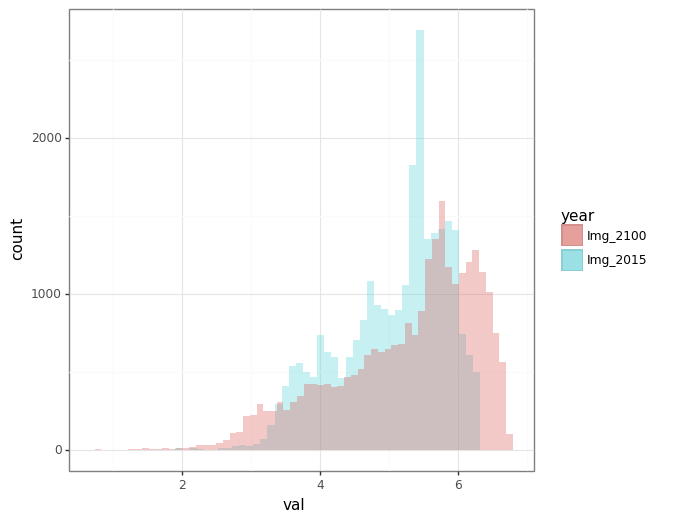

<ggplot: (8789457167649)>

In [ ]:
# instantiate the function to make plot
year_1 = 2015
year_2 = 2100
rcp  = '45'
water = 'Irrigated' # ['Irrigated','Rainfed']
crop = 'Wheat'    # ['Wheat','Maize','Wetland_rice]

img_1 = get_img(future_yield,year_1,rcp,water,crop,'future_yield')
img_2 = get_img(future_yield,year_2,rcp,water,crop,'future_yield')

plot_hist(img_1,f'Img_{year_1}',img_2,f'Img_{year_2}')

In [ ]:
# save the df to disk
future_yield.to_pickle('./result_csv/future_yield.pkl')

In [ ]:
future_yield

,crop,water,year,rcp,future_yield,future_yield_sd,future_yield_ci
0,Maize,Rainfed,2015,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Maize,Rainfed,2020,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Maize,Rainfed,2025,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Maize,Rainfed,2030,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Maize,Rainfed,2035,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...,...,...
427,Wheat,Irrigated,2080,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
428,Wheat,Irrigated,2085,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
429,Wheat,Irrigated,2090,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
430,Wheat,Irrigated,2095,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
